# H1 DATA 512 -- Homework 1
### Keegan Freeman
### 10/5/22

# *Data Acquisition*

**import libraries and read csv**

In [1]:
import json, time, urllib.parse
import requests
import pandas as pd

dinos = pd.read_csv("dinosaurs.csv")

**Create constants needed for webscraping API**

*Note: 'User-Agent' should be altered for replicaiton or reproduction to author's creditials as should 'ARTICLE_TITLES' for replication*

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<kafreem3@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = dinos["name"]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015060100",
    "end":         "2022090100"    # this is likely the wrong end date
}


Create resusable function such that API request can be made easily and with different parameterized attributes. This heavily relies on constants defined in cell above. If above cell above is properly altered for replication then only article_title should be altered as well.

In [3]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Make a list representing all months between specified start_date and end_date in the format of %m_%Y. Addtionally make a list of dino_names for indexing purposes.

In [4]:
# Make our row and column names for our dataframe

import datetime
from dateutil.relativedelta import relativedelta

start_date = datetime.datetime(2015,6,1)
end_date = datetime.datetime(2022,9,1)

num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)-1

dates = []
for i in range(num_months):
    dates.append((start_date + relativedelta(months=+i)).strftime('%m_%Y'))

dino_names = ARTICLE_TITLES

## Desktop View Acquisition

Pull desktop dinosaur view data and associate with each dinosaur in given list with its month (%m_%Y). Store pulled data into 2D array of size [r x c] where 'r' represents dinosaur and each 'c' represents each month between specified start and end date. Finally, it's worth noting that data is not present for each dinosaur at each month so for these cases a 0 is stored instead. The value of 0 was determined to be appropriate after scouring pulled data for datapoints with 'views' equal to 0 and finding none. This indicates that 'null' points in pulled data are those with no 'views'

*Note: This process will take some time ~10-15 mintues*

In [5]:
print("Getting desktop pageview data for dinosaurs ")

desktop_dino_views = [[0]*num_months for i in range(len(dino_names))]

for dino_name in range(len(ARTICLE_TITLES)):
    single_dino_data = request_pageviews_per_article(ARTICLE_TITLES[dino_name])
    #print(single_dino_data['items'][0]['views'])
    
    for month in range(86):
        try:
            desktop_dino_views[dino_name][month] = single_dino_data['items'][month]['views']
        except (IndexError, KeyError) as error:
            desktop_dino_views[dino_name][month] = 0
            
print("Process completed...")

Getting desktop pageview data for dinosaurs 
Process completed...


Convert to pandas dataframe for analysis in steps below and save as .json for reproducibility. Next, print such to get idea of what the dataframe looks like.

In [6]:
desktop_dino_views = pd.DataFrame(desktop_dino_views)
desktop_dino_views.columns = dates
desktop_dino_views.index = dino_names
desktop_dino_views.to_json(r'dino_monthly_desktop_201506-202209.json')
print(desktop_dino_views)

                      06_2015  07_2015  08_2015  09_2015  10_2015  11_2015  \
name                                                                         
Coelosaurus antiquus       79       62       80       66       72       69   
Aachenosaurus            2671    13113    34235     5361    13502    12210   
Aardonyx                 1174      843      713      735      730      644   
Abdarainurus              684      440      480      420      362      349   
Abditosaurus             1919      505      428      542      442      419   
...                       ...      ...      ...      ...      ...      ...   
Zuniceratops             1081      878      905      896      851      753   
Zuolong                   356      313      342      353      327      279   
Zuoyunlong                209      396      171      219      249      193   
Zupaysaurus               840      636      567      609      565      476   
Zuul                      331      324      282      288      28

## Mobile View Acquisition

```
Pull mobiile-web dinosaur view data and associate with each dinosaur in given list with its month (%m_%Y). Store pulled data into 2D array of size [r x c] where 'r' represents dinosaur and each 'c' represents each month between specified start and end date. (Note: Must redefine 'ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE' before calling API function again.)

Next, pull mobile-app dinosaur view data and associate with a separate list.

Finally, it's worth noting that data is not present for each dinosaur at each month so for these cases a 0 is stored instead. The value of 0 was determined to be appropriate after scouring pulled data for datapoints with 'views' equal to 0 and finding none. This indicates that 'null' points in pulled data are those with no 'views'

Note: This process will take some time ~10-15 mintues
```



In [7]:
print("Getting mobile pageview data for dinosaurs ")

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015060100",
    "end":         "2022090100"    # this is likely the wrong end date
}

mobile_dino_views_1 = [[0]*num_months for i in range(len(dino_names))]

for dino_name in range(len(ARTICLE_TITLES)):
    single_dino_data = request_pageviews_per_article(ARTICLE_TITLES[dino_name],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)

    for month in range(86):
        try:
            mobile_dino_views_1[dino_name][month] = single_dino_data['items'][month]['views']
        except (IndexError, KeyError) as error:
            mobile_dino_views_1[dino_name][month] = 0
            
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015060100",
    "end":         "2022090100"    # this is likely the wrong end date
}

mobile_dino_views_2 = [[0]*num_months for i in range(len(dino_names))]

for dino_name in range(len(ARTICLE_TITLES)):
    single_dino_data = request_pageviews_per_article(ARTICLE_TITLES[dino_name],request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
    
    for month in range(86):
        try:
            mobile_dino_views_2[dino_name][month] = mobile_dino_views_2[dino_name][month] + single_dino_data['items'][month]['views']
        except (IndexError, KeyError) as error:
            mobile_dino_views_2[dino_name][month] = mobile_dino_views_2[dino_name][month] + 0
            
print("Process completed...")

Getting mobile pageview data for dinosaurs 
Process completed...


convert mobile_app and mobile_web lists into numpy arrays such to perform element-by-element addition to construct 'monthly mobile access'. 

In [8]:
import numpy as np

a = np.matrix(mobile_dino_views_1)
b = np.matrix(mobile_dino_views_2)
mobile_dino_views = a+b

Convert to pandas dataframe for analysis in steps below and save as .json for reproducibility. Next, print such to get idea of what the dataframe looks like.

In [9]:
mobile_dino_views = pd.DataFrame(mobile_dino_views)
mobile_dino_views.columns = dates
mobile_dino_views.index = dino_names
mobile_dino_views.to_json(r'dino_monthly_mobile_201506-202209.json')
print(mobile_dino_views)

                      06_2015  07_2015  08_2015  09_2015  10_2015  11_2015  \
name                                                                         
Coelosaurus antiquus       20       14       11       21       13       14   
Aachenosaurus             443      412      283      794      311      275   
Aardonyx                  528      343      256      301      351      286   
Abdarainurus              281      227      217      208      158      198   
Abditosaurus              832      446      264      292      328      317   
...                       ...      ...      ...      ...      ...      ...   
Zuniceratops              516      442      335      412      362      323   
Zuolong                   141       97       80       94       76       88   
Zuoyunlong                 22       87       53       37       37       41   
Zupaysaurus               336      205      217      235      204      186   
Zuul                      489      282      169      116       9

## Cumulative View Calculation

Create empty list for cumulative dinosaur views. Fill list with element-by-element addition between desktop and mobile views created in cells above. Convert cumulative dinosaur views to pandas dataframe for later analysis and save as .json for reproduction.

In [10]:
cum_dino_views = [0]*len(dino_names)

i = 0
for c in desktop_dino_views.index:
    for r in desktop_dino_views.columns:
        cum_dino_views[i] = cum_dino_views[i] + desktop_dino_views[r][c] + mobile_dino_views[r][c]
    i += 1

cum_dino_views = pd.DataFrame(cum_dino_views)
cum_dino_views.index = dino_names
cum_dino_views.columns = ["views"]
        
cum_dino_views.to_json(r'dino_monthly_cumulative_201506-202209.json')
print(cum_dino_views)

                       views
name                        
Coelosaurus antiquus   11472
Aachenosaurus         171378
Aardonyx               86649
Abdarainurus           15410
Abditosaurus            7489
...                      ...
Zuniceratops          105527
Zuolong                39440
Zuoyunlong             11252
Zupaysaurus            60406
Zuul                  195441

[1423 rows x 1 columns]


# Analysis

## Max Average & Min Average

Create series representing average of all months per dinosaur for both mobile and desktop views. Next, find dinosaur name of both the highest and lowest of these averages for both mobile and desktop views -- creating four more series.

In [11]:
desktop_ave = desktop_dino_views.mean(axis=1)
mobile_ave = mobile_dino_views.mean(axis=1)

highest_ave_desktop = desktop_dino_views.loc[[desktop_ave.idxmax()]]
lowest_ave_desktop = desktop_dino_views.loc[[desktop_ave.idxmin()]]
highest_ave_mobile = mobile_dino_views.loc[[mobile_ave.idxmax()]]
lowest_ave_mobile = mobile_dino_views.loc[[mobile_ave.idxmin()]]

Plot the time-series views of the dinosaurs found for the highest and lowest average dinosaurs in both mobile and desktop views. 

*Note: Lowest Average for Dekstop and Mobile will most likely overlap*

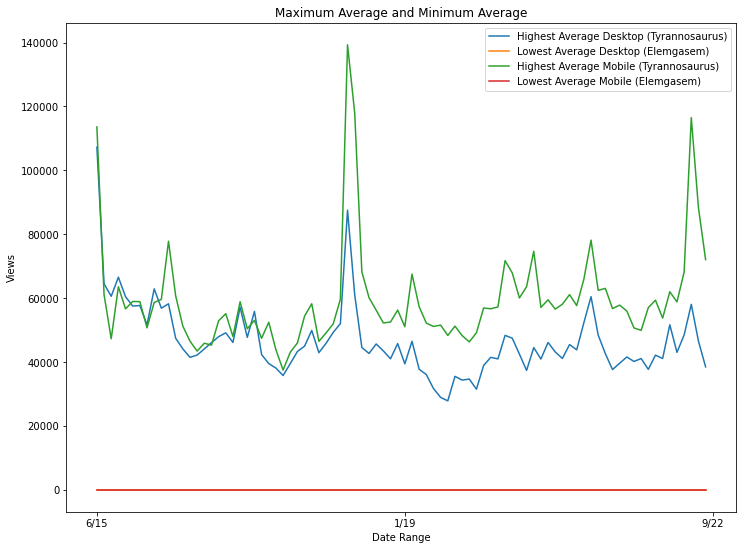

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))

plt.plot(np.arange(num_months), highest_ave_desktop.squeeze(), label=("Highest Average Desktop (" + str(desktop_ave.idxmax())+")"))
plt.plot(np.arange(num_months), lowest_ave_desktop.squeeze(), label=("Lowest Average Desktop (" + str(desktop_ave.idxmin())+")"))
plt.plot(np.arange(num_months), highest_ave_mobile.squeeze(), label=("Highest Average Mobile (" + str(mobile_ave.idxmax())+")"))
plt.plot(np.arange(num_months), lowest_ave_mobile.squeeze(), label=("Lowest Average Mobile (" + str(mobile_ave.idxmin())+")"))

ticks = [0,len(dates)/2,len(dates)]
labels = ["6/15", "1/19", "9/22"]
plt.xticks(ticks,labels)
plt.legend()
plt.xlabel("Date Range")
plt.ylabel("Views")
plt.title("Maximum Average and Minimum Average")
plt.savefig('Maximum_Average_and_Minimum_Average.png')
plt.show()

## Top 10 Peak Page Views

Create series for both desktop and mobile containing the peak page views for each month. Sort created series and remove all but the top 10 largest. 

Print to verify correctness.

In [14]:
desktop_peaks = desktop_dino_views.max(axis=1)
desktop_peaks = desktop_peaks.sort_values(ascending=False)
desktop_peaks = desktop_peaks.head(10)
print(desktop_peaks)

print()

mobile_peaks = mobile_dino_views.max(axis=1)
mobile_peaks = mobile_peaks.sort_values(ascending=False)
mobile_peaks = mobile_peaks.head(10)
print(mobile_peaks)

name
Achelousaurus     205150
Velociraptor      135741
Tyrannosaurus     107257
Halszkaraptor     103251
Giganotosaurus     62340
Spinosaurus        61029
Lythronax          57701
Nigersaurus        57192
Borealopelta       53831
Dilophosaurus      53278
dtype: int64

name
Nigersaurus        235977
Deinocheirus       234704
Giganotosaurus     165007
Therizinosaurus    155431
Velociraptor       142284
Achelousaurus      140592
Tyrannosaurus      139326
Borealopelta       117282
Dilophosaurus       78537
Argentinosaurus     78437
dtype: int32


Plot the time-series views of the top-ten dinosaurs, in terms of peaks, for both mobile and desktop views.

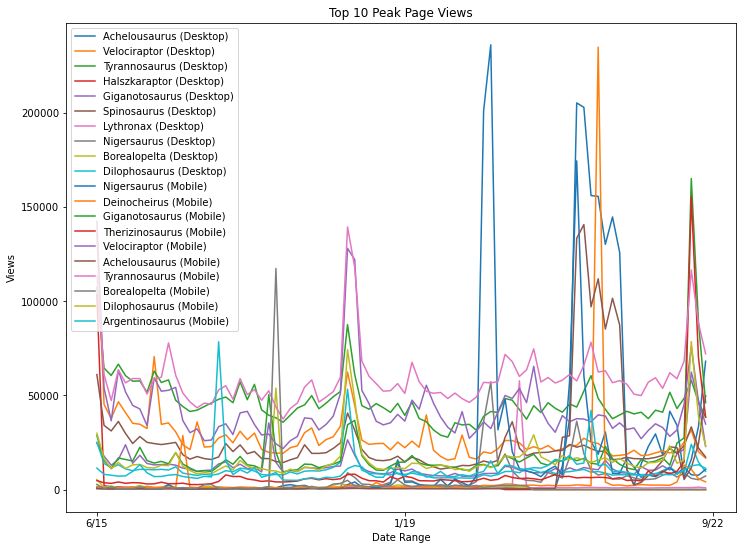

In [15]:
plt.figure(figsize=(12,9))

# Desktop Time Series Plotting
for i in desktop_peaks.index:
    plt.plot(np.arange(num_months), desktop_dino_views.loc[[i]].squeeze(), label=i+" (Desktop)")
    
# Mobile Time Series Plotting
for i in mobile_peaks.index:
    plt.plot(np.arange(num_months), mobile_dino_views.loc[[i]].squeeze(), label=i+" (Mobile)")
    
ticks = [0,len(dates)/2,len(dates)]
labels = ["6/15", "1/19", "9/22"]
plt.xticks(ticks,labels)
plt.legend()
plt.xlabel("Date Range")
plt.ylabel("Views")
plt.title("Top 10 Peak Page Views")
plt.savefig('Top_10_Peak_Page_Views.png')
plt.show()

## Fewest Months of Data

Create series, for both desktop and mobile, of the dinosaurs with the *least* amount of available data. Print for intuition.

*Note: I am associating **no** available data with points containing 0 views based on the data-preprocessing step above assigning 0 to non-existent data.*

In [16]:
least_views_desktop = (desktop_dino_views == 0).sum(axis=1)
least_views_desktop = least_views_desktop.sort_values(ascending=False)
least_views_desktop = least_views_desktop.head(10)
print(least_views_desktop)

print()

least_views_mobile = (mobile_dino_views == 0).sum(axis=1)
least_views_mobile = least_views_mobile.sort_values(ascending=False)
least_views_mobile = least_views_mobile.head(10)
print(least_views_mobile)

name
Elemgasem                86
Tuebingosaurus           86
Jakapil                  85
Bisticeratops            85
Perijasaurus             85
Mbiresaurus              85
Iyuku                    84
Paralitherizinosaurus    82
Bashanosaurus            80
Dzharaonyx               80
dtype: int64

name
Tuebingosaurus           86
Elemgasem                86
Bisticeratops            85
Jakapil                  85
Perijasaurus             85
Mbiresaurus              85
Iyuku                    84
Paralitherizinosaurus    82
Bashanosaurus            80
Dzharaonyx               80
dtype: int64


Plot time-series data of top-ten dinosaurs, in terms of months of unavailability, for both mobile and desktop views.

*Note: The majority of these lines will be flat along the x-axis*

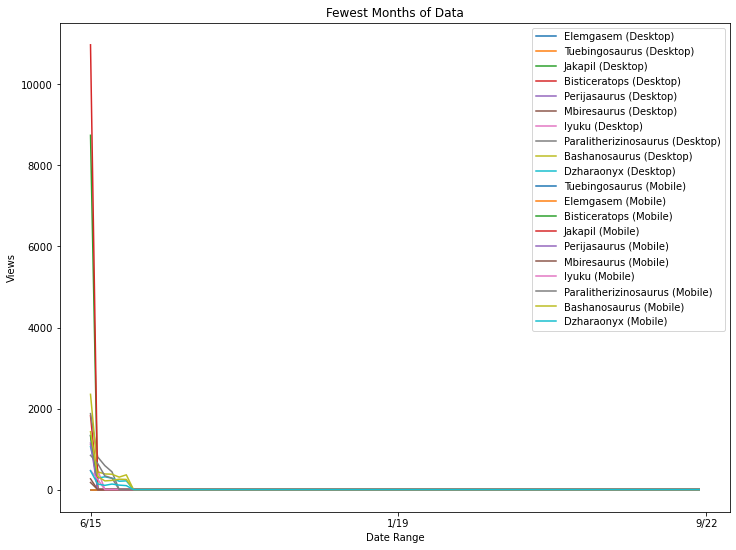

In [17]:
plt.figure(figsize=(12,9))

# Desktop Time Series Plotting
for i in least_views_desktop.index:
    plt.plot(np.arange(num_months), desktop_dino_views.loc[[i]].squeeze(), label=i+" (Desktop)")
    
# Mobile Time Series Plotting
for i in least_views_mobile.index:
    plt.plot(np.arange(num_months), mobile_dino_views.loc[[i]].squeeze(), label=i+" (Mobile)")
    
ticks = [0,len(dates)/2,len(dates)]
labels = ["6/15", "1/19", "9/22"]
plt.xticks(ticks,labels)
plt.legend()
plt.xlabel("Date Range")
plt.ylabel("Views")
plt.title("Fewest Months of Data")
plt.savefig('Fewest_Months_of_Data.png')
plt.show()